# Lyft BayWheel Exploration
## CE 263N Project
## Authors: Tianhao Wu, Kyuri Kim
Run with environment: skmob21

# Part 1: Data Gathering and Reading
**Describe here your data sets, demonstrate what you can read it at this point and list other data sets that you may extract. Display an illustrative image of your data. (e.g a table or a plot)**

[Data source: Lyft Bay Wheels](https://www.lyft.com/bikes/bay-wheels/system-data)

Lyft provides BayWheel history data spanning year 2017 to 2021-09. Each dataset includes columns like trip duration, start/end time, start/end station ID, start/end lon&lat, user type, etc. No trajectory data is provided in this historical dataset.

The Data set includeds:
- Trip Duration (seconds)
- Start Time and Date
- End Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Bike ID
- User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)


In this section of data gathering, We aim to achieve two tasks:
1. Load Single Month Data for data exploration
    - use method for easy adaption of another month data
    - Visualization:
        - Flow Diagram (point-point)
        - Flow Diagram (polygon-polygon)
        - "Population" Diagram. In this case frequency diagram. Heatmap of area.
2. Load Multiple data for comparison in time
    - Ultimate goal: drag time line to see development
        - Data set and computation will be huge. Might take too much resources

In [19]:
# importing required modules
import pandas as pd
import numpy as np
import zipfile

import matplotlib.pyplot as plt

import skmob
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point

## Station To Station Flow, Universal Method

Load the .zip file

In [20]:
## Load Zip FIle
def LoadZipFile(file_name):
    '''
    Input: File name in string
    Output: DataFrame of the file
    '''
    # Load .zip local data
    file_name = file_name
    zip_file = zipfile.ZipFile(file_name)
    df_csv = pd.read_csv(zip_file.open(zip_file.namelist()[0])) #solve Dirty zip file
    print('Complete Loading Zip File.')
    return df_csv

def LoadZipFileRemotely(url_string):
    # Alternatively: Load .zip remotely from https
    # Take time to download

    # Example
    #LoadZipFileRemotely('https://s3.amazonaws.com/baywheels-data/202106-baywheels-tripdata.csv.zip')
    import requests, zipfile
    from urllib.request import urlopen
    from io import BytesIO

    zip_file_url = url_string
    remote_zip_file = urlopen(zip_file_url)
    zipinmemory = BytesIO(remote_zip_file.read())
    zip_file = zipfile.ZipFile(zipinmemory)

    # the zipfile namelist can be filtered for smarter file loading
    # In this case, only load the first file from the zip archive 
    df_csv_re = pd.read_csv(zip_file.open(zip_file.namelist()[0]))
    return df_csv_re

Data Cleaning

In [21]:
def df_cleaning (df):
    before_cleaning = len(df)
    df.replace("", float("NaN"), inplace=True)
    df.dropna(inplace=True)
    after_cleaning = len(df)
    print('Original Dataframe has', before_cleaning, 'rows.')
    print (before_cleaning-after_cleaning, 'NaN or blank rows are dropped')
    print('Percentage of invalid rows:',np.round(100*(before_cleaning-after_cleaning)/(before_cleaning), 3),'%')
    print('Complete data frame cleaning.')
    return df

Craete Station reference dataframe with assigned index/ tile_ID.

In [22]:
#COMPLETE
# Create Station reference dataframe with assigned ID
def CreateStationDF(df_csv):
    '''
    Input: df_csv
    Output: station_df
    Dataframe with tile_ID assigned at each station for reference
    Includes both start&end_station_id
    '''
    # Get unique start & end station id
    unique_station_id = pd.concat([df_csv['start_station_id'],df_csv['end_station_id']], axis=0).unique()
    # Assign arbitary index for each station
    unique_station_tile_ID = np.arange(len(unique_station_id))
    station_df = pd.DataFrame({'station_id':unique_station_id, 'tile_ID':unique_station_tile_ID})
    station_df = station_df.dropna(axis=0) # Drop NaN station_id

    print('Created station tile reference dataframe')
    return station_df

Add the reference index/tileID to the dataframe loaded.

In [23]:
# COMPLETE
def AddTileID2DF (df_csv, station_df):
    '''
    Input: df_csv, station_df
    Output: df_csv_new, with tile_ID included for start & end
    as column names ['tile_ID_start', 'tile_ID_end']
    '''
    ## USE PANDAS MERGE
    df_csv_new = pd.merge(df_csv, station_df, left_on='start_station_id', right_on='station_id')
    df_csv_new.rename(columns={'tile_ID':'tile_ID_start'}, inplace=True)
    df_csv_new = pd.merge(df_csv_new, station_df, left_on='end_station_id', right_on='station_id')
    df_csv_new.rename(columns={'tile_ID':'tile_ID_end'}, inplace=True)
    df_csv_new = df_csv_new.drop(['station_id_x',  'station_id_y'], axis=1)
    
    print('Matched tile to loaded dataframe.')
    return df_csv_new

Compute coordinate of tile_ID by computting the mean lon-lng from its start/end lon-lng pairs.

In [24]:
pd.options.mode.chained_assignment = None  # default='warn' #CANCEL WARNING MESSAGES
# NEED TO OPTIMIZE
# Having trouble intaking large data set somehow??

def CreateStationTessDF (df_csv, station_df):
    '''
    Input: df_csv, station_df
    Output: Tessellation df. A geodataframe include tile_ID, geometry
    '''
    print('Start to create tessellation for loaded dataframe')
    station_df['geometry'] = ''
    station_df['start_frequency'] = ''
    station_df['return_frequency'] = ''
    for idx in np.arange(len(station_df)):
        current_station_id = station_df.iloc[idx]['station_id'] #'ABC-12' #FIXED KEY ERROR 213. stupid mistake of using loc. USE iloc for index.

        lat_array = []
        lng_array = []
        # Find lon lat of this station
        # Use both start & end station coordinates
        lat_array = np.append(lat_array, np.array(df_csv.loc[df_csv['start_station_id']==current_station_id]['start_lat']))
        lat_array = np.append(lat_array, np.array(df_csv.loc[df_csv['end_station_id']==current_station_id]['end_lat']))
        lng_array = np.append(lng_array, np.array(df_csv.loc[df_csv['start_station_id']==current_station_id]['start_lng']))
        lng_array = np.append(lng_array, np.array(df_csv.loc[df_csv['end_station_id']==current_station_id]['end_lng']))

        ## Geometry: Point or Polygon
        station_df['geometry'].loc[idx] = ArrayPoint(lng_array, lat_array)
        #station_df['geometry'][idx] = ArrayPolygon(lng_array, lat_array)

        #Frequency
        station_df['start_frequency'].loc[idx] = len(df_csv.loc[df_csv['start_station_id']==current_station_id])
        station_df['return_frequency'].loc[idx] = len(df_csv.loc[df_csv['end_station_id']==current_station_id])

        # drop '' or NaN
        #station_df
        #station_df = station_df.dropna()
        
        #gdf = gpd.GeoDataFrame(station_df,crs="EPSG:4326")
        gdf = gpd.GeoDataFrame(station_df)
        #gdf.replace("", float("NaN"), inplace=True)
        #gdf.dropna(inplace=True)
        
    print('Created Tessellation. ')
    return gdf

def ArrayPoint (lng_array, lat_array):
    lat_point = np.mean(lat_array)
    lng_point = np.mean(lng_array)
    return Point(lng_point, lat_point)


#####bug####
def ArrayPolygon (lng_array, lat_array):
    polygon_geom = Polygon(zip(lng_array, lat_array))
    # CAN take unorganized pair
    crs = {'init': 'epsg:4326'}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
    return polygon

Now we have two dataframes:
1. Tessellation dataframe, which contains
    - tile_ID
    - frequency
    - geometry
    - station_id
2. df_csv. 
    - ALL columns from data we loaded
    - tile_ID (joined from reference)

We want to generate FLOW dataframe from df_csv.
Flow Dataframe includes 3 columns:

FLow, Origin, Destination

In [25]:
# Goal: Given df_csv_new, Create a flow df
# Includes
# FLow, Origin, Destination
def CreateFlowDF_1 (df_csv, station_tess_df):
    df_flow = df_csv.groupby(['tile_ID_start', 'tile_ID_end']).size().reset_index(name='flow')
    fdf = skmob.FlowDataFrame(df_flow,tessellation=station_tess_df, tile_id='tile_ID',origin='tile_ID_start', destination='tile_ID_end')
    print('Created flow data frame.')
    return fdf

## Driver Code for Station to Station Flow Data Frame
Generating flow dataframe. Universal to any other .zip file from lyft data.

In [26]:
def Point2PointPipe(filepath):
    ''' 
    A pipline for creating point to point flow diagram
    Given file path
    Return 
    1. Modified Loaded Data
    2. Tessellation for station_id
    3. Flow data frame
    '''
    df_csv = LoadZipFile(filepath)
    df_csv = df_cleaning(df_csv)
    station_df = CreateStationDF(df_csv)
    df_csv_new = AddTileID2DF(df_csv, station_df)
    station_tess_df = CreateStationTessDF(df_csv_new, station_df)
    fdf = CreateFlowDF_1(df_csv_new, station_tess_df)
    
    return df_csv_new, station_tess_df, fdf

data, station_tess, fdf = Point2PointPipe('data/202109-baywheels-tripdata.csv.zip')

Complete Loading Zip File.
Original Dataframe has 212512 rows.
65699 NaN or blank rows are dropped
Percentage of invalid rows: 30.915 %
Complete data frame cleaning.
Created station tile reference dataframe
Matched tile to loaded dataframe.
Start to create tessellation for loaded dataframe
Created Tessellation. 
Created flow data frame.


/opt/anaconda3/envs/skmob21/lib/python3.7/site-packages/skmob/core/flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).
  warn("The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).")


In [27]:
# Sort flow from high to low
# Select highest frequency routes to visualize
fdf_sort = fdf.sort_values(by=['flow'],ascending=False).head(100)

# Visualization
# https://python-visualization.github.io/folium/modules.html#module-folium.map
# https://python-visualization.github.io/folium/
# Visualize with reference of:
# skMob-FlowDataFrame.ipynb
fdf_sort.plot_flows(flow_color='red',tiles='cartodbpositron', opacity=0.25,flow_weight=2, min_flow=0, zoom=9)

![Flow Diagram](data/code-img1.png)

## Tract To Tract Flow : Combined with Census Tract Data

Goal: Mapping station tessellation to census tract, Create new tessellation which use census tract as tile_ID. 

Each census tract includes several stations. We want to assign census tract number to each station given coordinates. 

Then use census tract tesselllation, and flow df to construct visualization.

Finally, I decided to use an open-sourced library named [censusgeocode](https://pypi.org/project/censusgeocode/) to get information about given coordinate. 

From [Census Bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2021&layergroup=Census+Tracts), I get shape file for tracts in california. 

In [28]:
# %pip install censusgeocode
import censusgeocode as cg 
# https://stackoverflow.com/questions/64983035/how-to-find-census-tract-from-latitude-and-longitude-in-python
# https://pypi.org/project/censusgeocode/

In [29]:
# Some Experiment Sample Code of cg
# Given : station_tess_df

# Access lat, lng from point object
lng = station_tess['geometry'].iloc[1].x
lat = station_tess['geometry'].iloc[1].y

# Use censusgeocode to get result of this coordinate pair
result = cg.coordinates(x=lng, y=lat)
# It will output a LONG result
#print(result)

# Access information about census tract
#result['Census Tracts'][0]

# Find TRACT value
sample_tract = result['Census Tracts'][0]['GEOID']
#sample_tract = result['Census Tracts'][0]['AREALAND']
print('GEOID value of given coordinate is:', sample_tract)

GEOID value of given coordinate is: 06075061508


In [30]:
# Complete
def AddGeoid2Tess (station_tess_df): 
    '''
    Given tessellation dataframe about station_id
    Return an extra column of this tessellation named census_tract
    which is TRACT number get from censusgeocode library
    '''
    station_tess_df_new = station_tess_df.copy()
    station_tess_df_new['GEOID'] = '' #Initialize a column
    station_tess_df_new['AREALAND'] = ''
    for r in np.arange(len(station_tess_df)):
        lng = station_tess_df['geometry'].iloc[r].x
        lat = station_tess_df['geometry'].iloc[r].y
        result = cg.coordinates(x=lng, y=lat)
        station_tess_df_new['GEOID'].iloc[r] = result['Census Tracts'][0]['GEOID']
        station_tess_df_new['AREALAND'].iloc[r] = result['Census Tracts'][0]['AREALAND']


    return station_tess_df_new

# Since get census take 2second per coordinate to run
# ~500 rows of dataframe takes ~10mins to run
# To save time
# I stored the value I got in the .csv file 


#station_tess_df_new = AddGeoid2Tess(station_tess)
# Run Once
#station_tess_df_new.to_csv('data/station_tess_df_new.csv') 

In [31]:
# Read the ran stored file 
df = pd.read_csv('data/station_tess_df_new.csv')
station_tess = df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1)
station_tess.head(5)

,station_id,tile_ID,geometry,start_frequency,return_frequency,GEOID,AREALAND
0,SF-N23,0,POINT (-122.4155145982936 37.76374969108682),483,523,6075017700,904078
1,SF-H30,1,POINT (-122.3879459085228 37.78297245382424),635,559,6075061508,227943
2,OK-I4,2,POINT (-122.2717615 37.81701539999999),19,20,6001401400,754768
3,OK-D3-1,3,POINT (-122.2644881 37.84036429999999),100,86,6001400600,297856
4,SF-I30,4,POINT (-122.3903237474495 37.78051879624513),943,939,6075060701,1292507


In [32]:
def AttachGeoid2Data (data):
   # Attach GEOID to station_tess_df_new, complementary to tile_ID
   data['GEOID_start'] = ''
   data['GEOID_end'] = ''
   # Go through rows of data
   for r in np.arange(len(data)):
      # Find tile_start GEOID
      data['GEOID_start'].iloc[r] = station_tess[data.iloc[r]['tile_ID_start'] == station_tess['tile_ID']].iloc[0]['GEOID']
      data['GEOID_end'].iloc[r] = station_tess[data.iloc[r]['tile_ID_end'] == station_tess['tile_ID']].iloc[0]['GEOID']

   return data


# Write in data as .csv Since running it takes a long time.

## Run Once
#data = AttachGeoid2Data(data)
#data.to_csv('data/202109-baywheels-tripdata_geoid.csv') 


## Checkpoint: data w/ geoid
Since data, tessellation are stored as .csv
We can run from here to save time.

In [34]:
# Read the file
data = pd.read_csv('data/202109-baywheels-tripdata_geoid.csv')
print(len(data))
data.head(3)

#for r in np.arange(len(data)):
#    data['GEOID_start'].iloc[r] = int(data['GEOID_start'].iloc[r])
#    data['GEOID_end'].iloc[r] = int(data['GEOID_end'].iloc[r])

# change type of geoid to int
data['GEOID_start'].astype(int)
data['GEOID_end'].astype(int)
data

146813


,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,tile_ID_start,tile_ID_end,GEOID_start,GEOID_end
0,0,9515818787165EA3,electric_bike,2021-09-22 13:30:57,2021-09-22 13:41:40,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Civic Center/UN Plaza BART Station (Market St ...,SF-I25,37.763686,-122.415521,37.780897,-122.412124,member,0,67,6075017700,6075017604
1,1,BC612400B29A857F,classic_bike,2021-09-05 18:16:29,2021-09-05 18:26:42,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Civic Center/UN Plaza BART Station (Market St ...,SF-I25,37.763735,-122.415524,37.781074,-122.411738,member,0,67,6075017700,6075017604
2,2,9629EF06B65FA57C,electric_bike,2021-09-28 10:01:42,2021-09-28 10:10:19,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Civic Center/UN Plaza BART Station (Market St ...,SF-I25,37.763712,-122.415471,37.781008,-122.411916,casual,0,67,6075017700,6075017604
3,3,1173DBE2ECDE0406,electric_bike,2021-09-18 11:05:53,2021-09-18 11:16:03,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Civic Center/UN Plaza BART Station (Market St ...,SF-I25,37.763746,-122.415556,37.780525,-122.412544,casual,0,67,6075017700,6075017604
4,4,1D69E65D634339B0,electric_bike,2021-09-14 13:40:21,2021-09-14 13:51:52,2nd St at Townsend St,SF-I30,Civic Center/UN Plaza BART Station (Market St ...,SF-I25,37.780517,-122.390484,37.781128,-122.411634,member,4,67,6075060701,6075017604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146808,146808,79E577CC2AD23FCB,classic_bike,2021-09-18 14:28:56,2021-09-18 14:35:55,Foothill Blvd at Harrington Ave,OK-K17,23rd Ave at Foothill Blvd,OK-L14,37.779930,-122.217728,37.785192,-122.234382,member,393,230,6001407200,6001405901
146809,146809,26EB26F738C9F7F3,classic_bike,2021-09-12 18:08:24,2021-09-12 18:13:35,San Antonio Park,OK-L12,23rd Ave at Foothill Blvd,OK-L14,37.790140,-122.242373,37.785192,-122.234382,casual,439,230,6001405902,6001405901
146810,146810,7EB2233ABC0CC817,classic_bike,2021-09-18 22:14:01,2021-09-18 22:22:26,Fruitvale BART Station,OK-N17,Foothill Blvd at Harrington Ave,OK-K17,37.775232,-122.224498,37.779930,-122.217728,casual,271,393,6001406100,6001407200
146811,146811,95C9E8F81D9B5111,classic_bike,2021-09-18 22:13:44,2021-09-18 22:22:18,Fruitvale BART Station,OK-N17,Foothill Blvd at Harrington Ave,OK-K17,37.775232,-122.224498,37.779930,-122.217728,casual,271,393,6001406100,6001407200


In [35]:
# Explore Shape file
locations = gpd.read_file('data/tl_2021_06_tract/tl_2021_06_tract.shp')

# GEOID have an extra 0 for each row
# Delete it.
for r in np.arange(len(locations)):
    locations['GEOID'].iloc[r] = int(locations['GEOID'].iloc[r])
locations.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,085,504321,6085504321,5043.21,Census Tract 5043.21,G5020,S,1450237,0,+37.3931319,-121.8651427,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06,085,504410,6085504410,5044.10,Census Tract 5044.10,G5020,S,1102136,0,+37.4093719,-121.8788884,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06,085,507003,6085507003,5070.03,Census Tract 5070.03,G5020,S,9529865,0,+37.2199936,-121.9979512,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."


In [36]:
# Groupby GEOID
tess_geoid = pd.DataFrame(station_tess.groupby('GEOID').sum()).drop(axis=1,columns='tile_ID')
tess_geoid['tile_ID'] = tess_geoid.index
tess_geoid.reset_index(level=0, inplace=True)
tess_geoid

# Add polygon for each tile_ID
tess_geoid = tess_geoid.merge(locations, on='GEOID')
#tess_geoid_clean = tess_geoid[['GEOID', 'geometry','start_frequency', 'return_frequency']]
tess_geoid_clean = tess_geoid[['GEOID', 'geometry','start_frequency', 'return_frequency']]

# Turn tess_geoid into a gpd dataframe
tess_geoid = gpd.GeoDataFrame(tess_geoid)
tess_geoid_clean = gpd.GeoDataFrame(tess_geoid_clean)
#tess_geoid # 212 rows

In [37]:
data_grouped = data.groupby(['GEOID_start', 'GEOID_end']).size().reset_index(name='flow')
data_grouped

,GEOID_start,GEOID_end,flow
0,6001400300,6001400300,101
1,6001400300,6001400400,32
2,6001400300,6001400500,7
3,6001400300,6001400600,12
4,6001400300,6001400700,2
...,...,...,...
11245,6085505100,6085501800,1
11246,6085505100,6085501901,1
11247,6085505100,6085503112,3
11248,6085505100,6085503709,2


In [38]:
# Now we have data, and tessellation
# Create flow dataframe
data_grouped = data.groupby(['GEOID_start', 'GEOID_end']).size().reset_index(name='flow')
fdf = skmob.FlowDataFrame(data_grouped,tessellation=tess_geoid_clean, tile_id='GEOID',origin='GEOID_start', destination='GEOID_end')
print('There are', len(fdf), 'OD pairs of flows generated from', len(data),'rides.')

There are 11250 OD pairs of flows generated from 146813 rides.


Map Visualization:

[Folium map](https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-data)

In [39]:
# Plot the spatial tessellation on a Folium map.
fdf.plot_tessellation(popup_features=['tile_ID', 'start_frequency', 'return_frequency'], zoom=10) 

In [40]:
fdf_sort = fdf.sort_values(by=['flow'],ascending=False).head(200)
fdf_sort

,origin,destination,flow
2021,6075010500,6075010500,1456
9665,6075060701,6075010500,569
2112,6075010500,6075060701,481
7891,6075022600,6075060701,458
6099,6075017700,6075017700,455
...,...,...,...
10306,6075061503,6075017700,96
2630,6075011700,6075061503,96
10325,6075061503,6075022600,95
9762,6075060701,6075061506,95


In [41]:
# Sort by significance
fdf_sort = fdf.sort_values(by=['flow'],ascending=False).head(200)

# Visualization of Top sorted flows
fdf_sort.plot_flows(flow_color='red',tiles='cartodbpositron', opacity=0.25,flow_weight=2, min_flow=0, zoom=10)

#fdf.plot_flows(flow_color='red',tiles='cartodbpositron', opacity=0.25,flow_weight=2, min_flow=0, zoom=10)

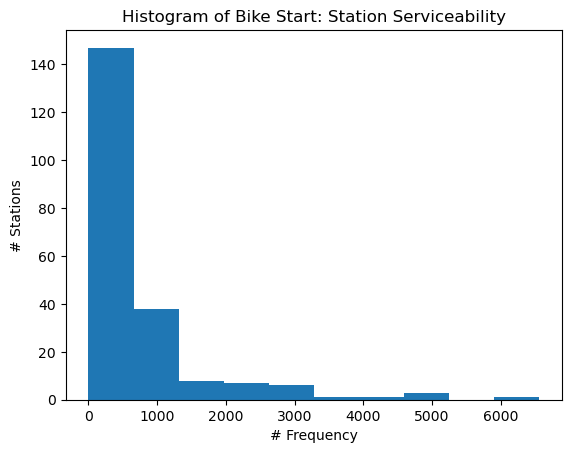

## TO-DO: Time Probability Distribution (Eigenbehavior)
Given monthly data, find the probability of starting the bike during each hours of per day.

We can also reference this to MOD2 eigenbehavior

### TO-DO

df_csv assign new column for hour block

Groupby hour block for each day, aggregate size

Plot histogram distribution

### Travel behavior: Distribution of bikesharing trip duration

In [73]:
import datetime

data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])

def timedelta_to_min (start_time, end_time):
    '''Input 2 series of datetime object
    Output 1 serires of int with unit min'''
    delta_time = end_time - start_time
    delta_time_min = []
    for i, value in enumerate(delta_time):
        second = delta_time[i].total_seconds()
        minite = int(second/60) %60
        delta_time_min.append(minite)
    
    return delta_time_min

delta_time_min = timedelta_to_min (data['ended_at'], data['started_at'])
data['duration'] = delta_time_min # add new column 'duration'

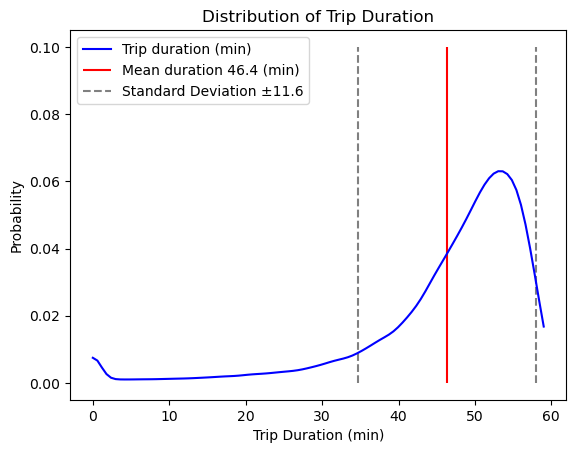

In [241]:
# Import the libraries
from scipy.stats.kde import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linspace

# Mean trip duration
duration_avg = np.mean(data['duration'])
duration_std = np.std(data['duration'])

# Probability of trip duration
fig = plt.figure()
kde_duration = gaussian_kde(data['duration'])
dist_space = linspace( min(data['duration']), max(data['duration']), 100 )
plt.plot( dist_space, kde_duration(dist_space), color='blue', label='Trip duration (min)')
label_str = 'Mean duration {} (min)'.format(np.round(duration_avg,1))
plt.vlines(duration_avg, ymin=0, ymax=0.1, color='red', label=label_str)
plt.vlines(duration_avg+duration_std, ymin=0, ymax=0.1, color='grey', linestyles='dashed', label='Standard Deviation ±{}'.format(np.round(duration_std,1)))
plt.vlines(duration_avg-duration_std, ymin=0, ymax=0.1, color='grey', linestyles='dashed')
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (min)')
plt.ylabel('Probability')
plt.legend(loc=2)
plt.savefig('output/TripDuration.png')
plt.show()


In [165]:
# Get hour started, hour ended data
hour_started = []
hour_ended = []
for i, value in enumerate(data['started_at']):
    hour_started.append(data['started_at'][i].hour+data['started_at'][i].hour/60)
    hour_ended.append(data['ended_at'][i].hour+data['ended_at'][i].hour/60)

hour_started_avg = np.round(np.mean(hour_started),1)
hour_ended_avg = np.round(np.mean(hour_ended),1)

hour_started = np.round(hour_started,1)
hour_ended = np.round(hour_ended,1)


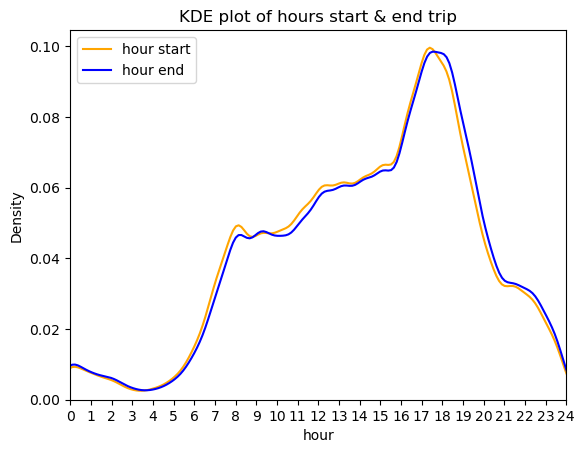

In [223]:
import seaborn as sns
fig = plt.figure()
sns.kdeplot(data=hour_started,color='orange', label='hour start', bw_adjust=1.2)
#plt.vlines(hour_started_avg, ymin=0, ymax=0.1, color='', linestyles='dashed') no point
sns.kdeplot(data=hour_ended,color='blue', label = 'hour end', bw_adjust=1.2)
plt.xlabel('hour')
plt.title('KDE plot of hours start & end trip')
plt.xticks(linspace(0,24,25))
plt.xlim(0,24)
plt.legend()
plt.savefig('output/hour-start-end-kde.png')
plt.show()

<Figure size 640x480 with 0 Axes>

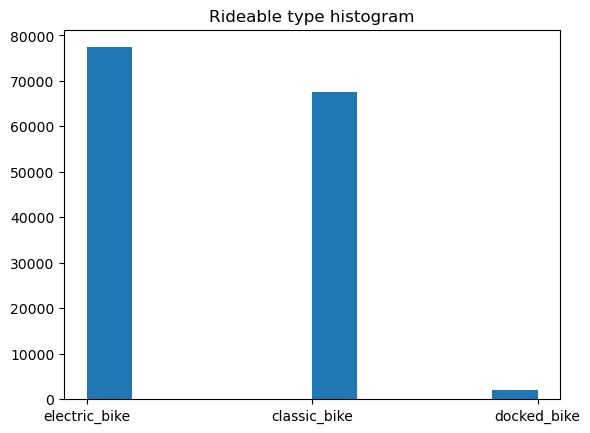

In [222]:
# Rideable Type
fig = plt.figure()
plt.hist(data['rideable_type'])
plt.title('Rideable type histogram')
plt.savefig('output/rideable_type_histogram.png')
plt.show()

<Figure size 640x480 with 0 Axes>

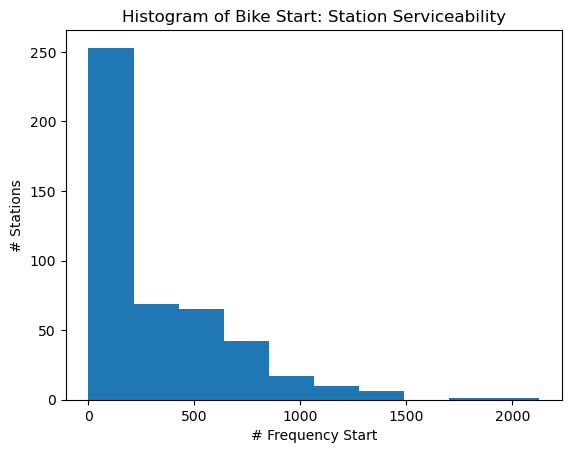

In [202]:
# Station serviceability
fig = plt.figure()
plt.hist(station_tess['start_frequency'])
plt.title('Histogram of Bike Start: Station Serviceability')
plt.ylabel('# Stations')
plt.xlabel('# Frequency Start')
plt.savefig('output/station_serviceability.png')
plt.show()

From histogram we can tell that there're some stations have start frequency greater than 1500 per month. Since there're no explit data about the size of these stations, we may assume that the size of the station, or bikes each station can store, are universal. The outliers stations may face issues of overuse, which may cause the shortage of bike for usage at some point in time. We want to find out what these stations are.

There're two outlier stations having frequency of starting a bike over 1500. They are *SF-J23-1*, *SF-G27*, and the station names are *Market St at 10th St* and *Powell St BART Station (Market St at 4th St)* respectively. It's reasonable to have these bike stations being overused since they're located at downtown San Francisco. However, to improve accessibility, we recommend ensuring these stations have enough bikes all the time for people to rent. It can be achieved through, either increase the size of the station to store more bikes, or build additional bike stations around these overused stations if possible. 

In [219]:
# Outlier stations
print('Overused stations ID: \n',station_tess.loc[station_tess['start_frequency']>1500]['station_id'])
print()
# Get station names
print('Overused stations names:')
print(data.loc[data['start_station_id']=='SF-J23-1'].iloc[0]['start_station_name'])
print(data.loc[data['start_station_id']=='SF-G27'].iloc[0]['start_station_name'])

Overused stations ID: 
 40     SF-J23-1
344      SF-G27
Name: station_id, dtype: object

Overused stations names:
Market St at 10th St
Powell St BART Station (Market St at 4th St)


# Part II: Data Analysis Plan (5pts)
Which methods studied in class you plan to apply. (note: you have to distribute different measurements for each member of the projects in groups).

1. FLow Data Frame: skMob-FlowDataFrame_Oct19.ipynb
    - O-D pairs of stations
    - O-D pairs of census tract
2. Travel Behavior Analysis (Eigenbehavior)
    - Time distribution of biking
3. Trip Distribution

# Part III: Research Story (5pts)
Select a paper related with the selected dataset describe their findings here. It does not have to be exactly the same data. It is only important that you read and refer here something published about an analysis of the similar kind of network you chose. After you select a data set of your interest, we can help you to find other related articles for you to write about in you mini-project written report.

**Selected Research Paper:**

[Micromobility evolution and expansion](https://escholarship.org/content/qt96g9c9nd/qt96g9c9nd.pdf)

[Enhancing equitable service level](https://www.sciencedirect.com/science/article/abs/pii/S096669232030096X)

![OD distribution](data/rp-img1.png)

The article tracked the uses of bikes(Ford GoBike and JUMP Bike) in San Francisco. The data included origin and destination information of each trip. With that data, they figured out the frequency of use for each location and it is illustrated with images. Like this article, we came up with a figure showing the path by using origin and end location,and found out the frequency of each point. 

a change